In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Cargar el dataset
data = pd.read_csv('train.csv',sep=",")

In [4]:
# Convertir la columna 'date' a datetime y establecerla como índice
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Resamplear los datos a nivel mensual, sumando el consumo
data_monthly = data.groupby('substation').resample('ME').sum()

# Lista de subestaciones únicas
substations = data['substation'].unique()

In [5]:
# Código para obtener el outlier más alejado (en valor absoluto) para cada subestación
def outlier_mas_alejado_por_subestacion(data):
    outliers_list = []
    subestaciones = data['substation'].unique()
    
    for substation in subestaciones:
        substation_data = data[data['substation'] == substation]
        Q1 = substation_data['consumption'].quantile(0.25)
        Q3 = substation_data['consumption'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definir los límites para identificar outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtrar los outliers
        outliers = substation_data[(substation_data['consumption'] < lower_bound) | (substation_data['consumption'] > upper_bound)]
        
        if not outliers.empty:
            # Encontrar el outlier más alejado (valor absoluto)
            outlier_mas_alejado = outliers.loc[outliers['consumption'].abs().idxmax()]
            outliers_list.append({
                'substation': substation,
                'date': outlier_mas_alejado.name.strftime('%d-%m-%Y %H:%M'),  # Formato dd-mm-aaaa hh:mm
                'consumption': outlier_mas_alejado['consumption']
            })
    
    return pd.DataFrame(outliers_list)

# Obtener el outlier más alejado por subestación
outliers_mas_alejados = outlier_mas_alejado_por_subestacion(data)

# Mostrar el resultado
print(outliers_mas_alejados)




  substation              date  consumption
0    AJAHUEL  03-04-2021 23:00   348.887471
1       BUIN  21-03-2019 17:00     6.623003
2      CHENA  29-05-2021 20:00   486.400665
3     CNAVIA  12-05-2018 23:00   752.006309
4    ELSALTO  04-04-2020 23:00   749.894004
5    FLORIDA  27-11-2021 05:00    91.916941
6    LOSALME  08-11-2018 16:00   353.607154


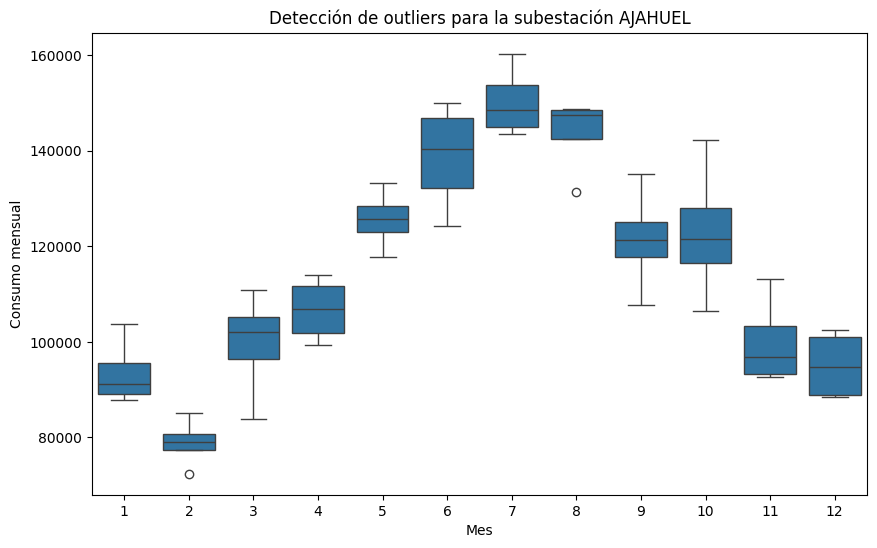

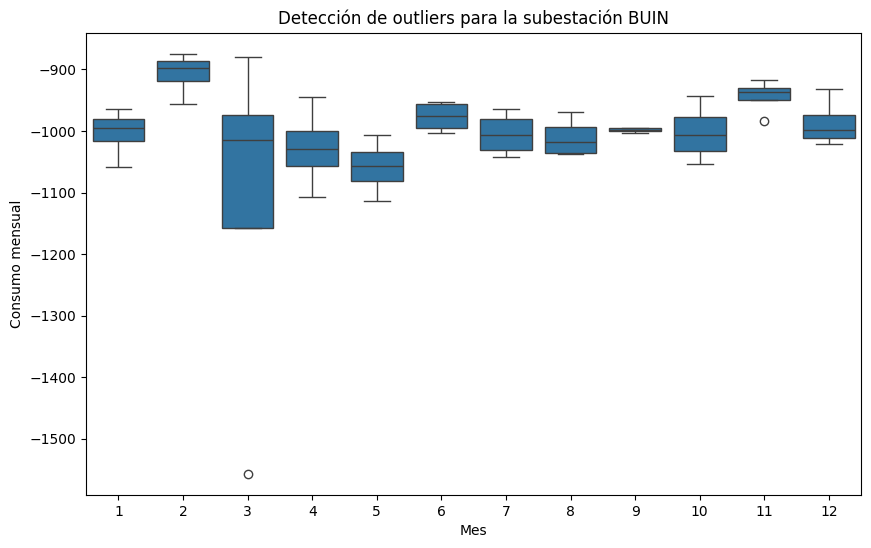

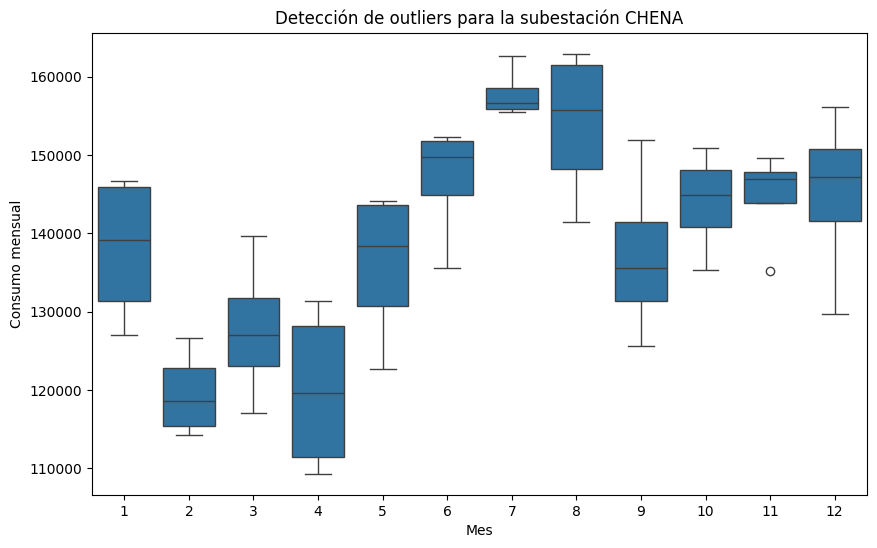

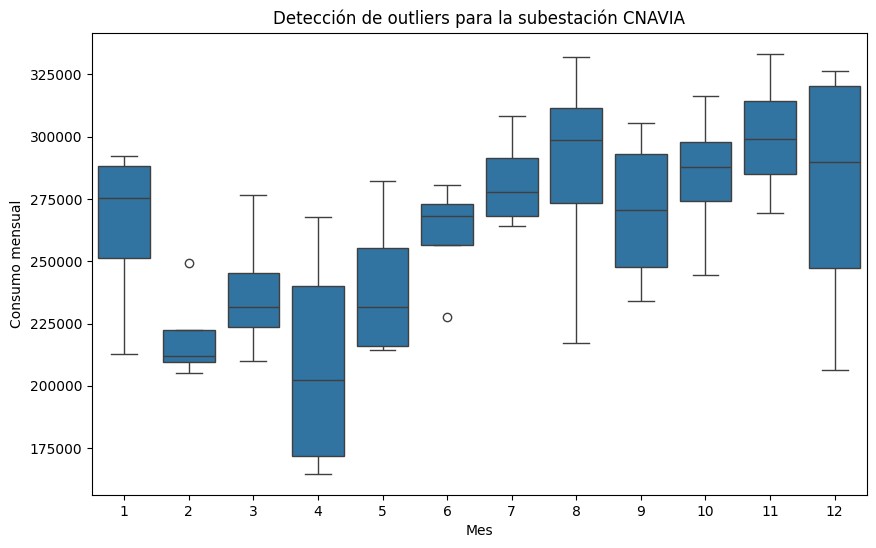

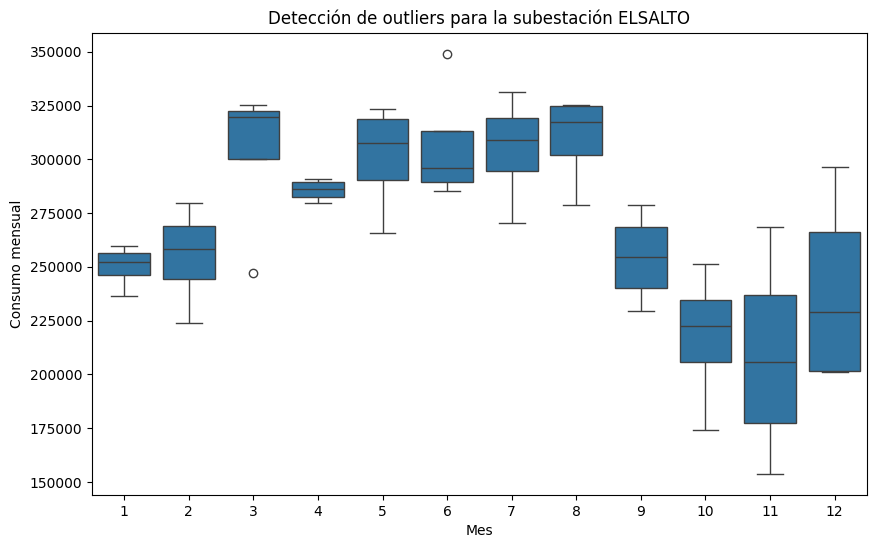

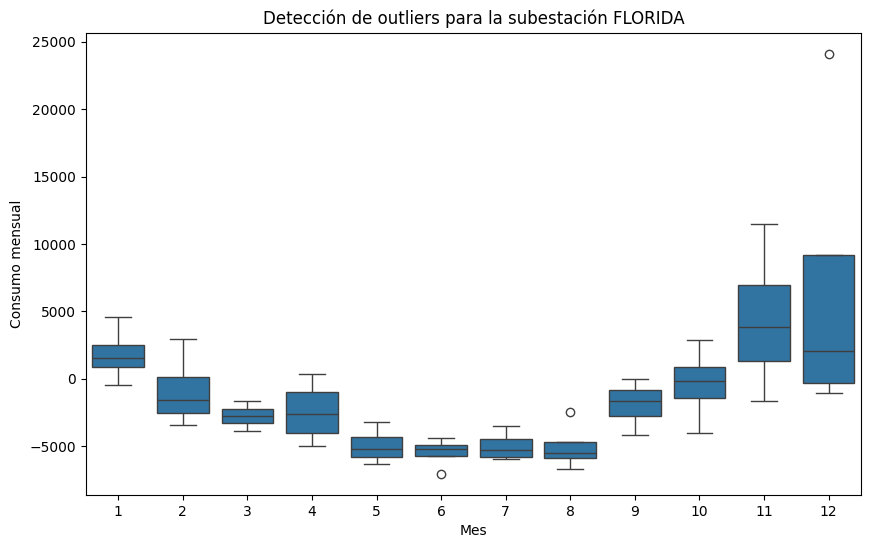

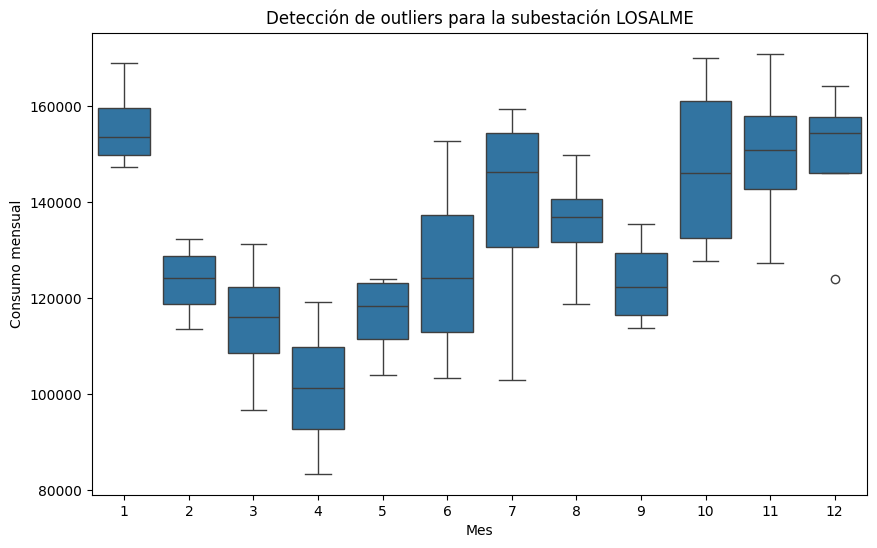

In [20]:
import seaborn as sns

# Función para detectar outliers en base al IQR por subestación y graficar
def graficar_outliers_por_subestacion(data):
    subestaciones = data.index.get_level_values('substation').unique()

    # Crear un gráfico de caja para cada subestación
    for substation in subestaciones:
        substation_data = data.loc[substation]
        
        # Crear un boxplot para el consumo mensual de cada subestación
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=substation_data.index.month, y=substation_data['consumption'])
        
        # Configurar los títulos y etiquetas
        plt.title(f"Detección de outliers para la subestación {substation}")
        plt.xlabel('Mes')
        plt.ylabel('Consumo mensual')
        
        # Mostrar el gráfico
        plt.show()

# Graficar los outliers para cada subestación
graficar_outliers_por_subestacion(data_monthly)


In [6]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

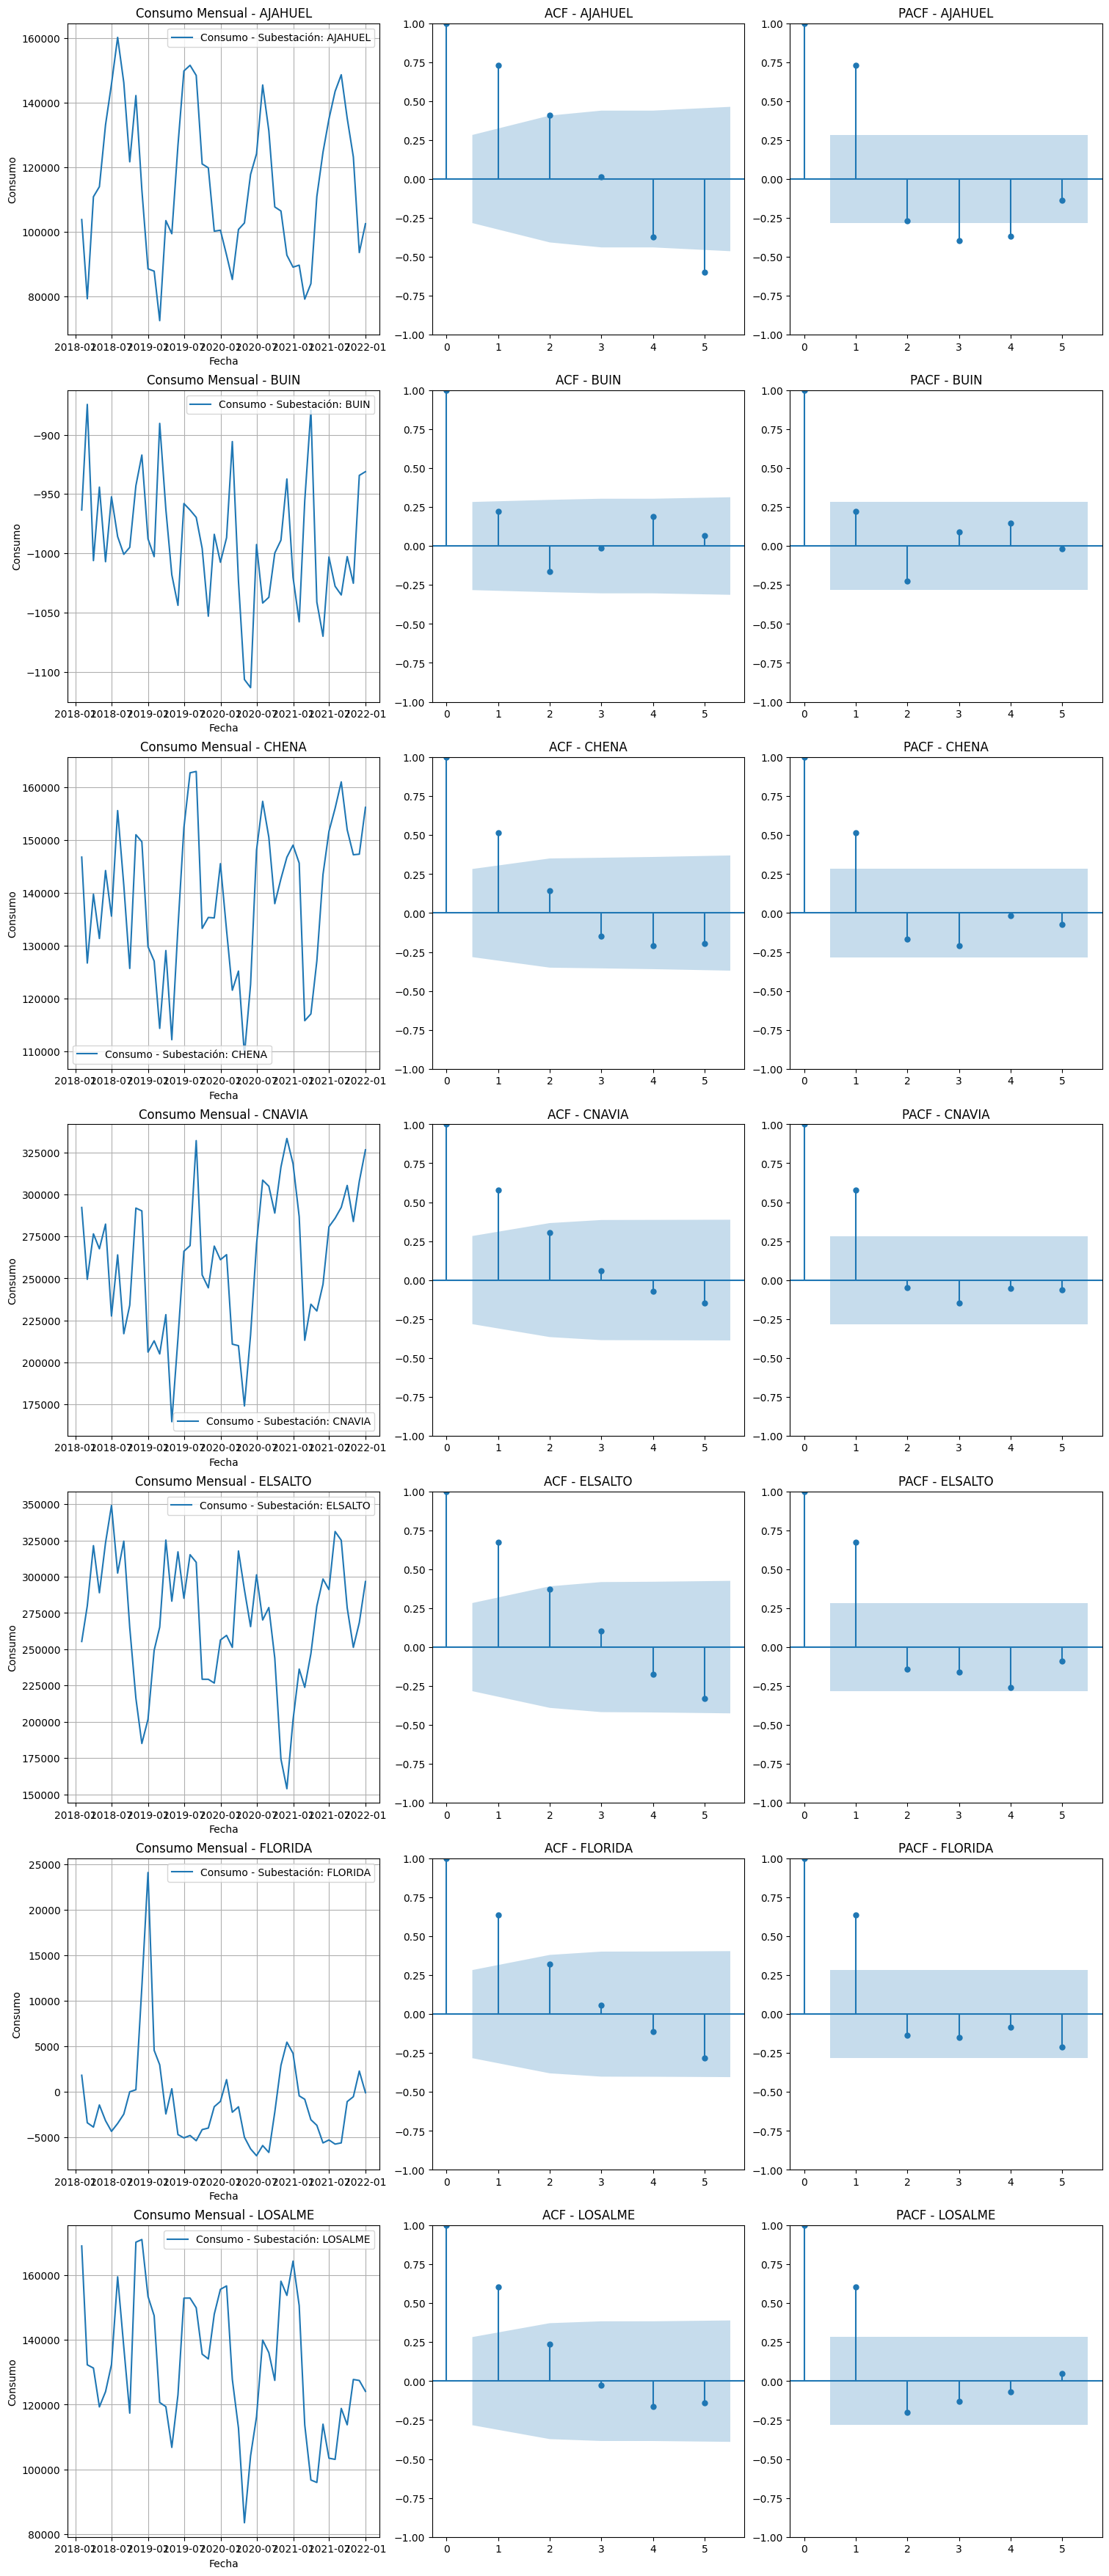

In [7]:
# Lista de subestaciones únicas
substations = data['substation'].unique()

# Número de gráficos por fila y por columna
n_cols = 3
n_rows = (len(substations) * 3 + n_cols - 1) // n_cols  # Calcular el número de filas necesarias

num_lags = 5

# Crear una figura con subgráficas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)

# Aplanar el array de ejes para facilitar la iteración
axes = axes.flatten()

# Contador para la posición actual de ejes
current_axis = 0

# Crear gráficos para cada subestación
for substation in substations:
    # Filtrar los datos para la subestación actual
    substation_data = data_monthly.xs(substation, level='substation')['consumption']
    
    # Graficar el consumo mensual
    ax = axes[current_axis]
    ax.plot(substation_data.index, substation_data, label=f'Consumo - Subestación: {substation}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Consumo')
    ax.set_title(f'Consumo Mensual - {substation}')
    ax.legend()
    ax.grid(True)
    current_axis += 1
    
    # Graficar la autocorrelación
    ax = axes[current_axis]
    plot_acf(substation_data, lags=num_lags, ax=ax)
    ax.set_title(f'ACF - {substation}')
    current_axis += 1
    
    # Graficar la autocorrelación parcial
    ax = axes[current_axis]
    plot_pacf(substation_data, lags=num_lags, ax=ax)
    ax.set_title(f'PACF - {substation}')
    current_axis += 1

# Eliminar cualquier eje no utilizado si hay menos gráficos que subgráficas
for i in range(current_axis, len(axes)):
    fig.delaxes(axes[i])

# Mostrar los gráficos
plt.show()